In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from ACP_functions import display_corr_circle, display_factorial_planes, display_scree_plot

import warnings
warnings.filterwarnings("ignore")

In [2]:
SEED = 49

pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)

plt.rcParams['figure.figsize'] = [10, 8]

In [3]:
list_datasets = ['olist_customers_dataset',
 'olist_geolocation_dataset',
 'olist_orders_dataset',
 'olist_order_items_dataset',
 'olist_order_payments_dataset',
 'olist_order_reviews_dataset',
 'olist_products_dataset',
 'olist_sellers_dataset',
 'product_category_name_translation']

In [5]:
for dataset in list_datasets:
    globals()[dataset] = pd.read_csv((os.path.join('datasets','exploration', dataset)+'.csv'))

In [ ]:
f0 = open('dictionnaries\dict_customer_unique.json')
f1 = open('dictionnaries\dict_order_customer_unique.json')
f2 = open('dictionnaries\dict_trad_cat.json')

dict_customer_unique = json.load(f0)
dict_order_customer_unique = json.load(f1)
dict_trad_cat = json.load(f2)

In [ ]:
IMAGES_PATH = Path() / "img" / "simulations"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"essai - {fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

# Évaluation de la stabilité temporelle des clusters

Maintenant que nous avons défini notre partition optimal des clients de **Olist**, nous allons nous assurer de leur validité dans le temps.

L’objectif est de déterminer au bout de combien de temps le modèle de clustering entraîné initialement devient obsolète, c'est-à-dire que suffisamment de clients ont suffisamment interagi avec **Olist** durant une certaine période et ne font plus partie du cluster auquel ils ont été assignés en début de période, cette situation nécessitant d’entraîner à nouveau le modèle de clustering sur la base des données à mises à jour.

Pour quantifier la stabilité de notre segmentation nous allons calculer l'**indice de Rand** entre la partition obtenue initialement et celles obtenues à partir des modèles nouvellements entraînés sur une base données plus récente.

<u>**Nous considérerons comme stable un notre partitionnement tant que l'indice de Rand reste au-dessus de 0.8**</u>.

Pour accélerer les calculs, nous regrouperons dans un premier temps les commandes par mois, puis par semaine lorsque nous saurons entre quels mois le passage sous la valeur de 0.8 pour l'indice de Rand s'effectue.

In [7]:
olist_orders_dataset['customer_unique_id'] = olist_orders_dataset['customer_id'].map(dict_customer_unique)

olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset['order_purchase_timestamp'])
olist_orders_dataset['period_start'] = olist_orders_dataset['order_purchase_timestamp']

olist_orders_dataset.set_index("period_start", inplace=True)
olist_orders_months, olist_orders_weeks = olist_orders_dataset.copy(), olist_orders_dataset.copy()

olist_orders_months = olist_orders_dataset.to_period(freq='M')
olist_orders_weeks = olist_orders_dataset.to_period(freq='W')

olist_orders_months.reset_index(inplace=True)
olist_orders_weeks.reset_index(inplace=True)

olist_orders_months.sort_values(by='period_start', ascending=True, inplace=True)
olist_orders_weeks.sort_values(by='period_start', ascending=True, inplace=True)

olist_orders_months['period_start'] = olist_orders_months['period_start'].apply(str).apply(pd.Timestamp)
olist_orders_weeks['period_start'] = olist_orders_weeks['period_start'].apply(str).apply(pd.Timestamp)

olist_orders_months.reset_index(drop=True, inplace=True)
olist_orders_weeks.reset_index(drop=True, inplace=True)

olist_orders_months

,period_start,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,2016-09-01,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04,830d5b7aaa3b6f1e9ad63703bec97d23
1,2016-09-01,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,NaN,2016-10-20,b7d76e111c89f7ebf14761390f0f7d17
2,2016-10-01,f7310018040436b01ab03f81b301b5de,efec125e0fd56164c37c9f1e1c804cd7,delivered,2016-10-07 11:20:34,2016-10-07 12:14:56,2016-10-11 12:14:57,2016-10-14 12:14:57,2016-11-29,619b93ec47d01fd1228afef1a980abe3
3,2016-10-01,b44d71edad65f41824d2e177470ef8f6,ad29d9bb283d87e61e190d40bc7bc15b,delivered,2016-10-10 15:23:51,2016-10-10 16:02:57,2016-10-21 18:02:55,2016-10-24 18:02:55,2016-11-30,33fbcb38d3009eddfe53b3063c642959
4,2016-10-01,f716dffba1232aaef7c899fb8c14db97,cf5112cc5129776cc69c956dc265a5f7,delivered,2016-10-07 15:12:40,2016-10-07 15:59:25,2016-10-11 15:59:26,2016-10-14 15:59:26,2016-11-25,2552194579775fed6641fa5f56152e0a
...,...,...,...,...,...,...,...,...,...,...
98202,2018-08-01,a27bc60b5829ed193c7a85e25f6de764,76539c8bd72f278e7b8e3cb0aeeaaa20,delivered,2018-08-06 23:11:28,2018-08-06 23:24:38,2018-08-07 14:16:00,2018-08-10 10:32:50,2018-08-17,82b6d31baa9c3905f4d3a9ec67db715b
98203,2018-08-01,40a9be4510459ae28841128e5938153f,063a4ff31bff767c4a8fe77696eb3892,delivered,2018-08-14 17:42:23,2018-08-14 18:15:24,2018-08-22 08:39:00,2018-08-27 20:38:27,2018-08-24,c1d2d91d3c622832dc1e41101b567492
98204,2018-08-01,1566e171c4b2ce6aae4f8d222097ef6e,52a4e084d8b7e51397a7168ee9be5960,delivered,2018-08-21 21:30:35,2018-08-21 21:45:20,2018-08-22 14:18:00,2018-08-27 15:36:39,2018-09-04,5ab6e955205058ae5491af57f51f0302
98205,2018-08-01,49873be3d163feec184f5afcaea61a47,6b7aa31cb6d5390e54b3b29b9e581db6,delivered,2018-08-02 17:18:48,2018-08-02 17:30:17,2018-08-03 11:48:00,2018-08-09 22:21:27,2018-08-15,b12e97cb3bf8d1b59fc21cfac8e9dfd4


In [101]:
list_total_months = [str(x).split(' 00')[0][:7] for x in olist_orders_months['period_start'].value_counts().sort_index(ascending=True).index]
list_total_months

['2016-09',
 '2016-10',
 '2016-12',
 '2017-01',
 '2017-02',
 '2017-03',
 '2017-04',
 '2017-05',
 '2017-06',
 '2017-07',
 '2017-08',
 '2017-09',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-01',
 '2018-02',
 '2018-03',
 '2018-04',
 '2018-05',
 '2018-06',
 '2018-07',
 '2018-08',
 '2018-09']

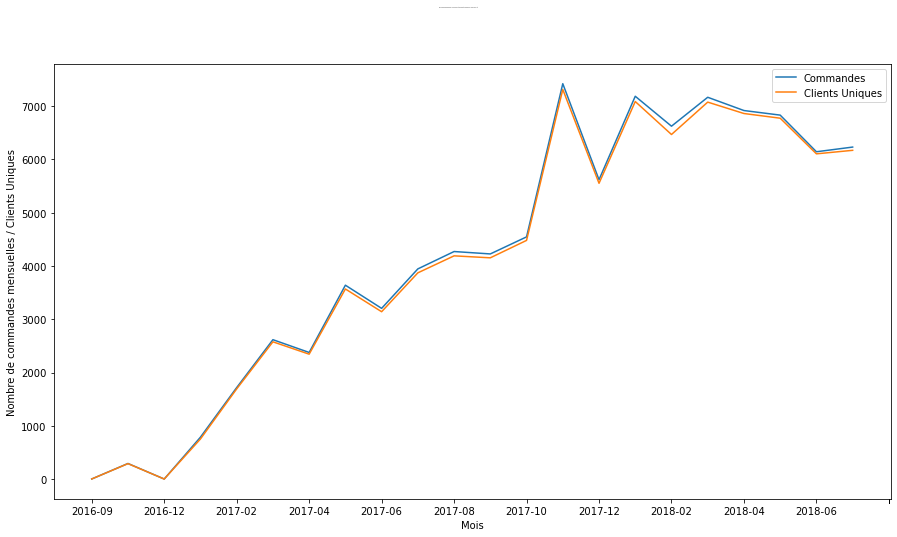

In [146]:
data_1 = olist_orders_months['period_start'].value_counts().sort_index(ascending=True).values[:-2]

data_2 = olist_orders_months.groupby(by='period_start').agg({'customer_unique_id':'nunique'})['customer_unique_id'].values[:-2]

sns.lineplot(x=list_total_months[:-2], y=data_1, label='Commandes')
sns.lineplot(x=list_total_months[:-2], y=data_2, label='Clients Uniques')

plt.xticks(ticks=[x if list_total_months.index(x)%2==0 else '' for x in list_total_months[:-2]]);
plt.xlabel('Mois')
plt.ylabel("Nombre de commandes mensuelles / Clients Uniques")
plt.suptitle("Nombre de commandes mensuelles et de clients uniques par mois sur Olist", fontsize=1)
plt.legend();

Afin de nous assurer que nous débuterons notre segmentation à une date où nous pourrons rencontrer tous les profils de clients dans la base de données, nous prenons comme date de départ le **début de l'année 2018**.

In [118]:
def make_clusters_dataset_monthly(df_period):

    # On se place au 1er jour du mois suivant les dernières commandes
    present_day = df_period['period_start'].max() + dt.timedelta(days=31)

    # RECENCY
    recency_df = pd.DataFrame(df_period.groupby(by='customer_unique_id')['order_purchase_timestamp'].max())
    recency_df['recency'] = recency_df['order_purchase_timestamp'].apply(lambda x: (present_day-x).days)
    del recency_df['order_purchase_timestamp']

    # FREQUENCY BINAIRE
    frequency_df = pd.DataFrame(df_period.groupby(["customer_unique_id"]).agg({"order_id":"nunique"}))
    frequency_df['frequency_bin'] = np.where(frequency_df['order_id']>1,1,0)
    del frequency_df['order_id']

    # MONETARY
    monetary_df = olist_order_payments_dataset[['order_id','payment_value']].copy()
    monetary_df = monetary_df[monetary_df['order_id'].isin(df_period['order_id'].unique())]
    monetary_df['customer_unique_id'] = monetary_df['order_id'].map(dict_order_customer_unique)
    monetary_df = monetary_df.groupby(by='customer_unique_id').sum()
    monetary_df.rename(columns={'payment_value':'monetary'}, inplace=True)

    # SATISFACTION MOYENNE
    mean_review_score_df = olist_order_reviews_dataset[['order_id','review_score']].copy()
    mean_review_score_df = mean_review_score_df[mean_review_score_df['order_id'].isin(df_period['order_id'].unique())]
    mean_review_score_df['customer_unique_id'] = mean_review_score_df['order_id'].map(dict_order_customer_unique)
    mean_review_score_df = mean_review_score_df[['review_score', 'customer_unique_id']].groupby(by='customer_unique_id').mean()
    mean_review_score_df.rename(columns={'review_score':'mean_review_score'}, inplace=True)

    df_cls = recency_df.merge(frequency_df, left_index=True, right_index=True)
    df_cls = df_cls.merge(monetary_df, left_index=True, right_index=True)
    df_cls = df_cls.merge(mean_review_score_df, left_index=True, right_index=True)
    df_cls.sort_index(ascending=True, inplace=True)
    
    df_cls_std = pd.DataFrame(StandardScaler().fit_transform(df_cls), columns=df_cls.columns, index=df_cls.index)

    kmeans_cls = KMeans(n_clusters=5, random_state=SEED)
    kmeans_cls.fit(df_cls_std)

    df_cls_std['clusters'] = kmeans_cls.labels_
    
    return df_cls_std, kmeans_cls

In [134]:
plt.rcParams['figure.figsize'] = [15, 8]

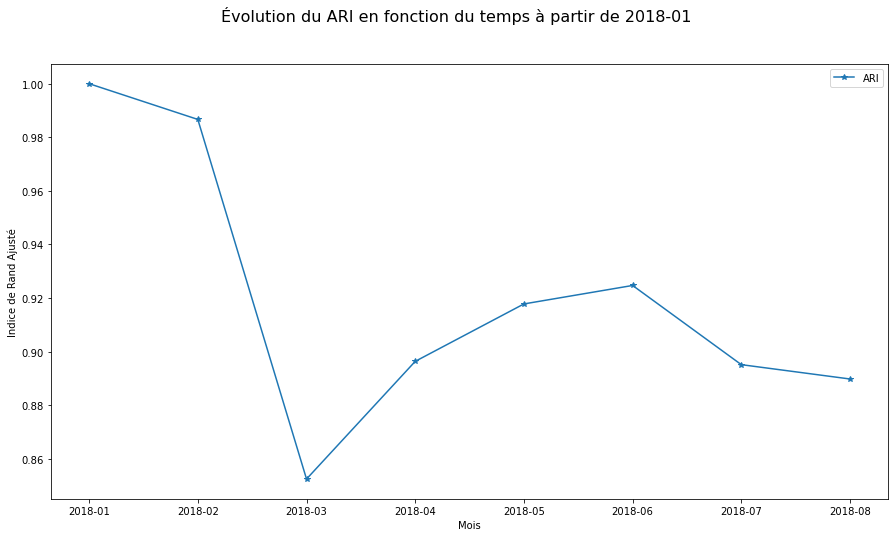

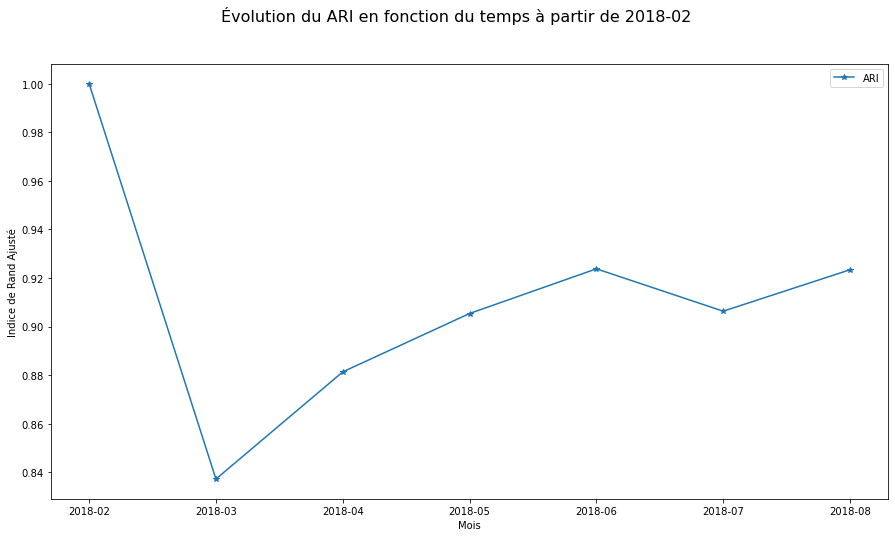

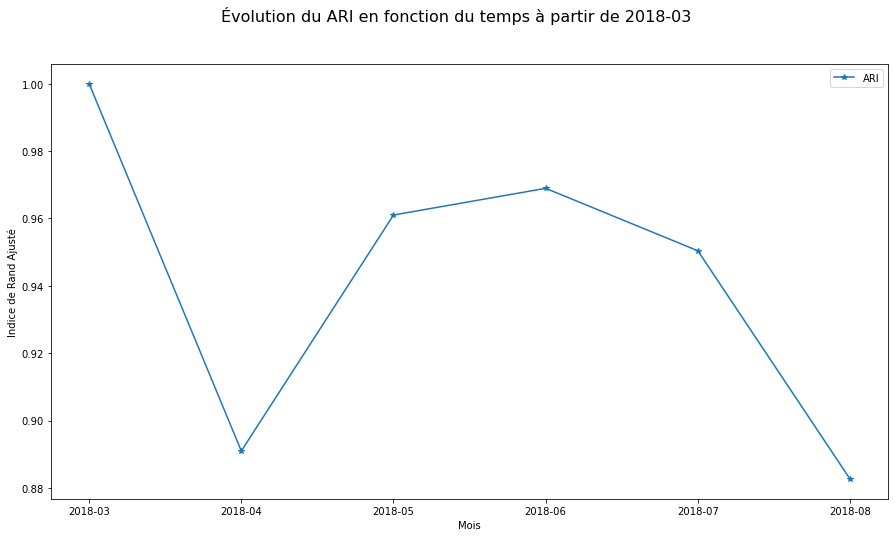

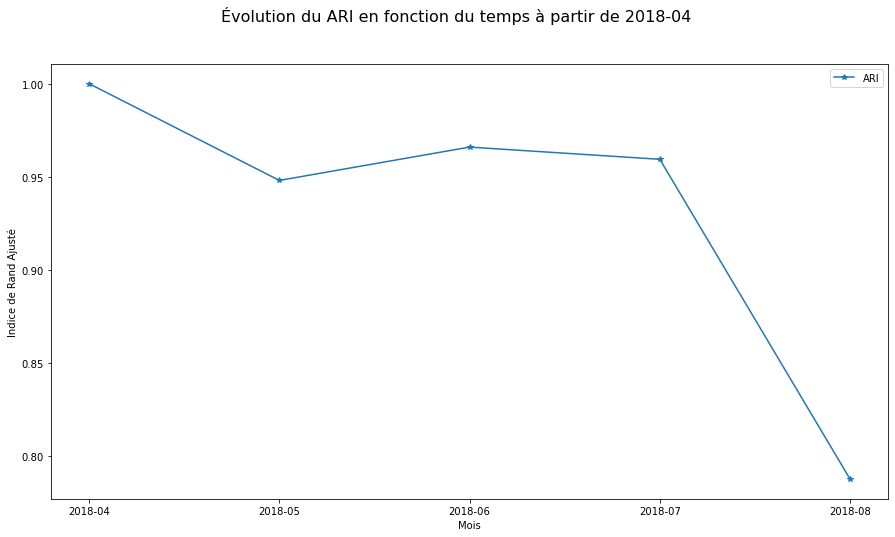

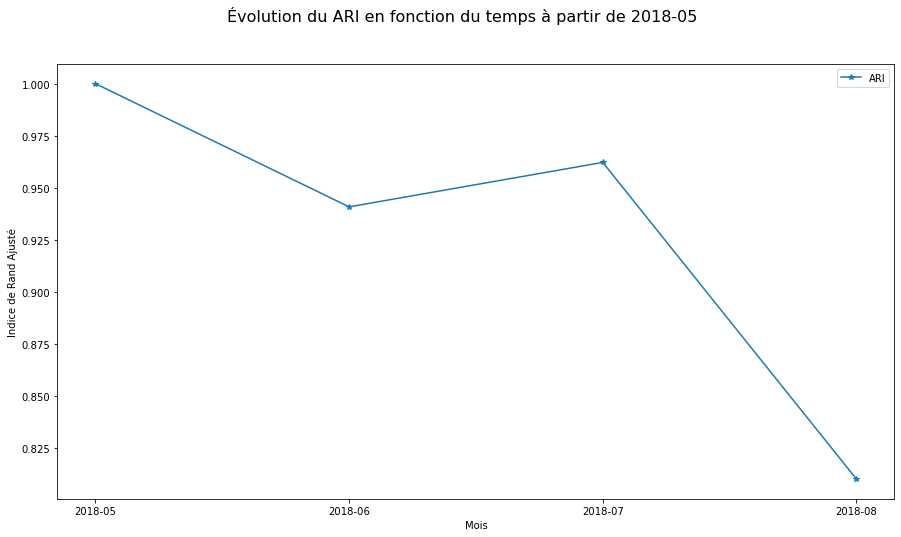

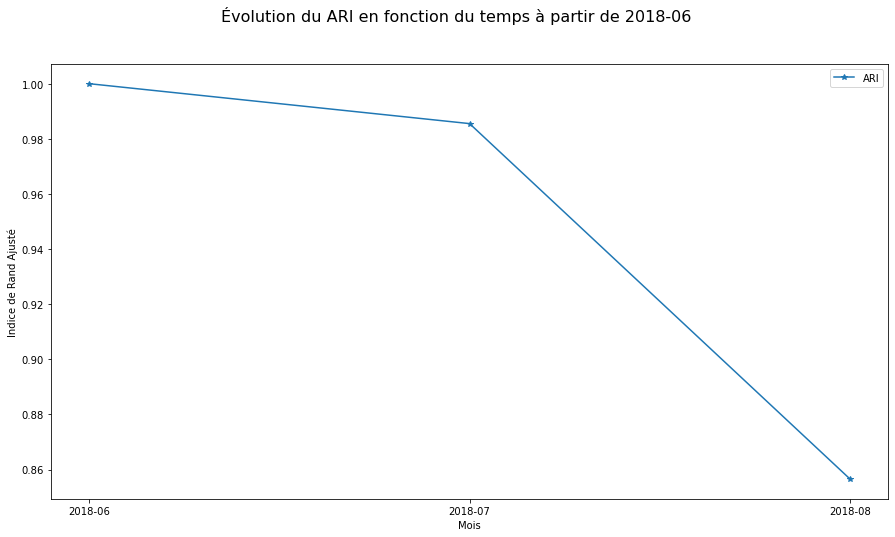

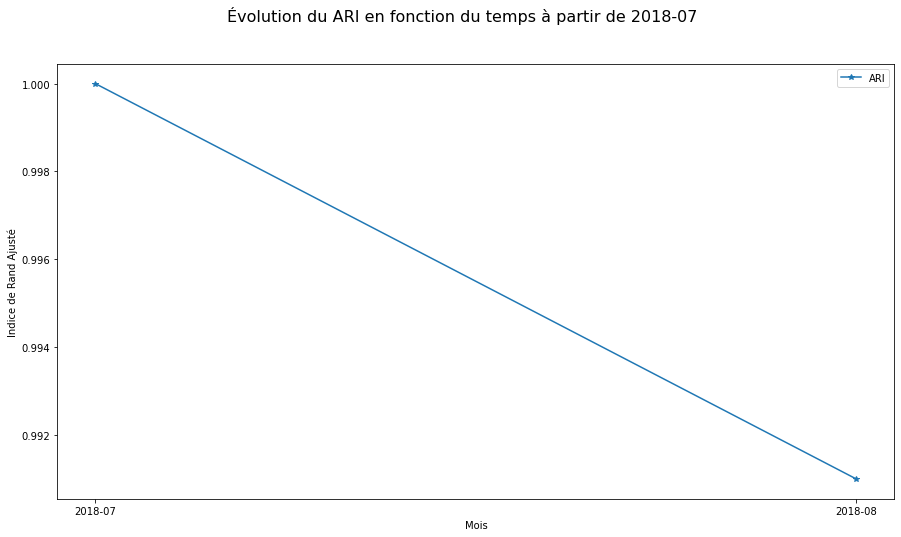

In [194]:
for analysis_date_start in list_total_months[list_total_months.index('2018-01'):-2]:

    dict_evol_olist_orders = dict()

    for i in range(0,len(list_total_months)-list_total_months.index(analysis_date_start)-1):
        dict_evol_olist_orders[list_total_months[list_total_months.index(analysis_date_start)+i]] = \
            olist_orders_months[olist_orders_months['period_start']<pd.Timestamp(analysis_date_start)+i*dt.timedelta(days=31)]
        globals()['olist_orders_months_'+str(i)] = \
            olist_orders_months[olist_orders_months['period_start']<pd.Timestamp(analysis_date_start)+i*dt.timedelta(days=31)]


    unique_customers_init = make_clusters_dataset_monthly(dict_evol_olist_orders[list(dict_evol_olist_orders.keys())[0]])[0].index
    kmeans_init = make_clusters_dataset_monthly(dict_evol_olist_orders[list(dict_evol_olist_orders.keys())[0]])[1]
    labels_init = kmeans_init.labels_

    dict_evol_df_custers = {key:make_clusters_dataset_monthly(dict_evol_olist_orders[key])[0] for key in list(dict_evol_olist_orders.keys())[1:]}

    dict_evol_ARI = dict()
    dict_evol_ARI[list(dict_evol_olist_orders.keys())[0]] = 1
    for key, value in dict_evol_df_custers.items():
        df = value.copy()
        df = df.loc[unique_customers_init]
        dict_evol_ARI[key] = adjusted_rand_score(df['clusters'], kmeans_init.predict(df.drop(columns=['clusters'])))

    plt.plot(dict_evol_ARI.keys(), dict_evol_ARI.values(), linestyle='-', marker='*', label='ARI')

    plt.xlabel('Mois')
    plt.ylabel("Indice de Rand Ajusté")
    plt.suptitle(f"Évolution du ARI en fonction du temps à partir de {analysis_date_start}", fontsize=16)
    plt.legend()
    save_fig(f"Évolution du ARI en fonction du temps à partir de {analysis_date_start}")
    plt.show();

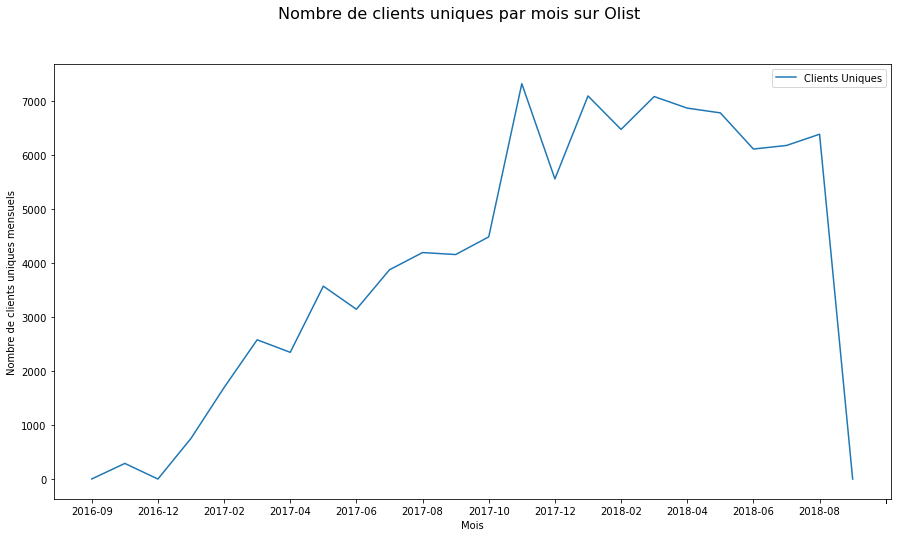

In [176]:
new_customers = olist_orders_months.groupby(by='period_start').agg({'customer_unique_id':'nunique'})['customer_unique_id'].values

sns.lineplot(x=list_total_months, y=new_customers, label='Clients Uniques')

plt.xticks(ticks=[x if list_total_months.index(x)%2==0 else '' for x in list_total_months]);
plt.xlabel('Mois')
plt.ylabel("Nombre de clients uniques mensuels")
plt.suptitle("Nombre de clients uniques par mois sur Olist", fontsize=16)
plt.legend();